In [10]:
%pip install micromlgen

ERROR: Could not find a version that satisfies the requirement micromlgen (from versions: none)
ERROR: No matching distribution found for micromlgen
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import itertools

#from micromlgen import port

from skimage.color import rgb2lab

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report

import xgboost as xgb


import data

In [2]:
colors_df = pd.read_csv("./data_labeled.csv", usecols=["red", "green", "blue", "label"])

add combined features

In [24]:
noise = colors_df[['red', 'green', 'blue']].min(axis=1)
colors_df['diff_min_red'] = colors_df['red'] - noise
colors_df['diff_min_green'] = colors_df['green'] - noise
colors_df['diff_min_blue'] = colors_df['blue'] - noise

maxval = colors_df[['red', 'green', 'blue']].max(axis=1)
colors_df['diff_max_red'] = maxval - colors_df['red']
colors_df['diff_max_green'] = maxval - colors_df['green']
colors_df['diff_max_blue'] = maxval - colors_df['blue']

In [72]:
## skip this block. this are all the features i could come up with.
colors_df['intensity'] = colors_df['red'] + colors_df['green'] + colors_df['blue']
colors_df['intensity_percieved'] = 0.2126 * colors_df['red'] + 0.7152 * colors_df['green'] + 0.0722 * colors_df['blue']

colors_df['red_norm'] = colors_df['red'] / colors_df['intensity']
colors_df['green_norm'] = colors_df['green'] / colors_df['intensity']
colors_df['blue_norm'] = colors_df['blue'] / colors_df['intensity']

colors_df['ratio_rg'] = colors_df['red'] / colors_df['green']
colors_df['ratio_rb'] = colors_df['red'] / colors_df['blue']
colors_df['ratio_gr'] = colors_df['green'] / colors_df['red']
colors_df['ratio_gb'] = colors_df['green'] / colors_df['blue']
colors_df['ratio_br'] = colors_df['blue'] / colors_df['red']
colors_df['ratio_bg'] = colors_df['blue'] / colors_df['green']

colors_df['red_z'] = (colors_df['red'] - colors_df['red'].mean()) / colors_df['red'].std()
colors_df['green_z'] = (colors_df['green'] - colors_df['green'].mean()) / colors_df['green'].std()
colors_df['blue_z'] = (colors_df['blue'] - colors_df['blue'].mean()) / colors_df['blue'].std()

rgb = colors_df[['red', 'green', 'blue']].div(colors_df['intensity'], axis=0)
hsv = mcolors.rgb_to_hsv(rgb.to_numpy())
colors_df['hue'] = hsv[:, 0]
colors_df['saturation'] = hsv[:, 1]
colors_df['value'] = hsv[:, 2]

colors_df['sin_hue'] = np.sin(2 * np.pi * colors_df['hue'])
colors_df['cos_hue'] = np.cos(2 * np.pi * colors_df['hue'])

rgb_arr = rgb.to_numpy().reshape((-1, 1, 3))
lab = rgb2lab(rgb_arr).reshape((-1, 3))

colors_df['L_lab'] = lab[:, 0]
colors_df['a_lab'] = lab[:, 1]
colors_df['b_lab'] = lab[:, 2]

# Normalized to max channel
max_channel = rgb.max(axis=1)
colors_df['red_max_norm'] = rgb['red'] / max_channel
colors_df['green_max_norm'] = rgb['green'] / max_channel
colors_df['blue_max_norm'] = rgb['blue'] / max_channel

# Dominance score
colors_df['dominance'] = (rgb.max(axis=1) - rgb.min(axis=1)) / colors_df['intensity']

# Channel differences (raw)
colors_df['red_minus_green'] = colors_df['red'] - colors_df['green']
colors_df['red_minus_blue'] = colors_df['red'] - colors_df['blue']
colors_df['green_minus_blue'] = colors_df['green'] - colors_df['blue']

# Channel differences normalized by intensity
colors_df['rg_norm_diff'] = (colors_df['red'] - colors_df['green']) / colors_df['intensity']
colors_df['gb_norm_diff'] = (colors_df['green'] - colors_df['blue']) / colors_df['intensity']
colors_df['rb_norm_diff'] = (colors_df['red'] - colors_df['blue']) / colors_df['intensity']

# Non-linear transforms
colors_df['red_sq'] = colors_df['red'] ** 2
colors_df['green_sq'] = colors_df['green'] ** 2
colors_df['blue_sq'] = colors_df['blue'] ** 2

colors_df['red_green_prod'] = colors_df['red'] * colors_df['green']
colors_df['green_blue_prod'] = colors_df['green'] * colors_df['blue']
colors_df['red_blue_prod'] = colors_df['red'] * colors_df['blue']

# YCbCr components
R = rgb['red']
G = rgb['green']
B = rgb['blue']

Y = 0.299 * R + 0.587 * G + 0.114 * B
colors_df['Y'] = Y
colors_df['Cb'] = 0.564 * (B - Y)
colors_df['Cr'] = 0.713 * (R - Y)

# Opponent color channels
# O1 = (R - G)/√2
# O2 = (R + G - 2B)/√6
# O3 = (R + G + B)/√3  (basically intensity-normalized)
colors_df['O1'] = (R - G) / np.sqrt(2)
colors_df['O2'] = (R + G - 2 * B) / np.sqrt(6)
colors_df['O3'] = (R + G + B) / np.sqrt(3)

# Binary dominance indicators
colors_df['is_red_dom'] = (colors_df['red'] > colors_df['green']) & (colors_df['red'] > colors_df['blue']).astype(int)
colors_df['is_green_dom'] = (colors_df['green'] > colors_df['red']) & (colors_df['green'] > colors_df['blue']).astype(int)
colors_df['is_blue_dom'] = (colors_df['blue'] > colors_df['red']) & (colors_df['blue'] > colors_df['green']).astype(int)

# Channel ratios but clipped to avoid blow-ups
epsilon = 1e-6
colors_df['ratio_r_g_clipped'] = colors_df['red'] / (colors_df['green'] + epsilon)
colors_df['ratio_g_r_clipped'] = colors_df['green'] / (colors_df['red'] + epsilon)
colors_df['ratio_r_b_clipped'] = colors_df['red'] / (colors_df['blue'] + epsilon)
colors_df['ratio_b_r_clipped'] = colors_df['blue'] / (colors_df['red'] + epsilon)
colors_df['ratio_g_b_clipped'] = colors_df['green'] / (colors_df['blue'] + epsilon)
colors_df['ratio_b_g_clipped'] = colors_df['blue'] / (colors_df['green'] + epsilon)

# Channel log transforms (robust for large ranges)
colors_df['log_red'] = np.log(colors_df['red'] + 1)
colors_df['log_green'] = np.log(colors_df['green'] + 1)
colors_df['log_blue'] = np.log(colors_df['blue'] + 1)

# Log ratios
colors_df['log_r_g'] = colors_df['log_red'] - colors_df['log_green']
colors_df['log_r_b'] = colors_df['log_red'] - colors_df['log_blue']
colors_df['log_g_b'] = colors_df['log_green'] - colors_df['log_blue']

# Channel entropy (how balanced the RGB components are)
rgb_sum = colors_df['red'] + colors_df['green'] + colors_df['blue']
p_r = colors_df['red'] / rgb_sum
p_g = colors_df['green'] / rgb_sum
p_b = colors_df['blue'] / rgb_sum

colors_df['rgb_entropy'] = -(p_r*np.log(p_r+epsilon) + p_g*np.log(p_g+epsilon) + p_b*np.log(p_b+epsilon))

# Saturation variants (raw RGB-based saturation)
maxc = colors_df[['red', 'green', 'blue']].max(axis=1)
minc = colors_df[['red', 'green', 'blue']].min(axis=1)

colors_df['sat_range'] = maxc - minc
colors_df['sat_ratio'] = (maxc - minc) / (maxc + epsilon)

# Normalized differences between sorted channels
sorted_vals = np.sort(colors_df[['red', 'green', 'blue']].to_numpy(), axis=1)
colors_df['low_mid_diff'] = (sorted_vals[:, 1] - sorted_vals[:, 0])
colors_df['mid_high_diff'] = (sorted_vals[:, 2] - sorted_vals[:, 1])
colors_df['low_high_diff'] = (sorted_vals[:, 2] - sorted_vals[:, 0])

# Hue harmonics (higher-frequency circular features)
colors_df['sin2_hue'] = np.sin(4 * np.pi * hsv[:, 0])
colors_df['cos2_hue'] = np.cos(4 * np.pi * colors_df['hue'])

# LAB distances
colors_df['a_abs'] = colors_df['a_lab'].abs()
colors_df['b_abs'] = colors_df['b_lab'].abs()
colors_df['lab_chroma'] = np.sqrt(colors_df['a_lab']**2 + colors_df['b_lab']**2)

# Quadratic LAB interactions

rgb_arr = rgb.to_numpy().reshape((-1, 1, 3))
lab = rgb2lab(rgb_arr).reshape((-1, 3))

colors_df['L_sq'] = lab[:, 0]**2
colors_df['a_sq'] = colors_df['a_lab']**2
colors_df['b_sq'] = colors_df['b_lab']**2

colors_df['log_L_lab'] = np.log(colors_df['L_lab']+epsilon)
colors_df['log_a_lab'] = np.log(colors_df['a_lab']+epsilon)
colors_df['log_b_lab'] = np.log(colors_df['b_lab']+epsilon)

colors_df['La_prod'] = colors_df['L_lab'] * colors_df['a_lab']
colors_df['Lb_prod'] = colors_df['L_lab'] * colors_df['b_lab']
colors_df['ab_prod'] = colors_df['a_lab'] * colors_df['b_lab']

# Combined “warm” and “cool” metrics
colors_df['warm_score'] = colors_df['red'] - (colors_df['blue'] + colors_df['green'])/2
colors_df['cool_score'] = colors_df['blue'] - (colors_df['red'] + colors_df['green'])/2

# Color tilt (red-green axis orientation)
colors_df['rg_angle'] = np.arctan2(colors_df['green'], colors_df['red'])

# Luminance uniformity (smoothness across channels)
colors_df['channel_var'] = colors_df[['red', 'green', 'blue']].var(axis=1)

/nix/store/wmphz787a21jnwq6qyvb2vzwqayjz7nx-python3-3.12.11-env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
colors_df['green_norm'] = colors_df['green'] / (colors_df['red'] + colors_df['green'] + colors_df['blue'])

rgb = colors_df[['red', 'green', 'blue']].div((colors_df['red'] + colors_df['green'] + colors_df['blue']), axis=0)
rgb_arr = rgb.to_numpy().reshape((-1, 1, 3))
lab = rgb2lab(rgb_arr).reshape((-1, 3))
# Quadratic LAB interactions
colors_df['L_sq'] = lab[:, 0]**2

# Dominance score
colors_df['dominance'] = (rgb.max(axis=1) - rgb.min(axis=1)) / (colors_df['red'] + colors_df['green'] + colors_df['blue'])

colors_df['red_green_prod'] = colors_df['red'] * colors_df['green']
# Hue harmonics (higher-frequency circular features)

hsv = mcolors.rgb_to_hsv(rgb.to_numpy())
colors_df['sin2_hue'] = np.sin(4 * np.pi * hsv[:, 0])

In [4]:
colors_df

,red,green,blue,label,green_norm,L_sq,dominance,red_green_prod,sin2_hue
0,710.28,675.33,630.55,ripe,0.334959,1336.786892,0.000020,479673.3924,0.923193
1,691.39,659.01,646.43,ripe,0.330028,1304.805394,0.000011,455632.9239,0.553050
2,672.84,673.24,708.81,ripe,0.327628,1272.074510,0.000009,452982.8016,0.877435
3,778.34,643.31,644.30,ripe,0.311387,1255.049028,0.000032,500713.9054,-0.015355
4,694.93,640.96,623.57,ripe,0.327111,1300.689371,0.000019,445422.3328,0.488519
...,...,...,...,...,...,...,...,...,...
1217,661.50,589.80,572.60,unripe,0.323373,1292.755450,0.000027,390152.7000,0.394216
1218,642.30,586.10,570.10,unripe,0.325883,1297.801330,0.000022,376452.0300,0.447647
1219,636.40,578.80,569.70,unripe,0.324276,1289.238419,0.000021,368348.3200,0.281870
1220,642.60,588.70,582.70,unripe,0.324531,1287.593319,0.000018,378298.6200,0.208254


KeyError: 'log_L_lab'

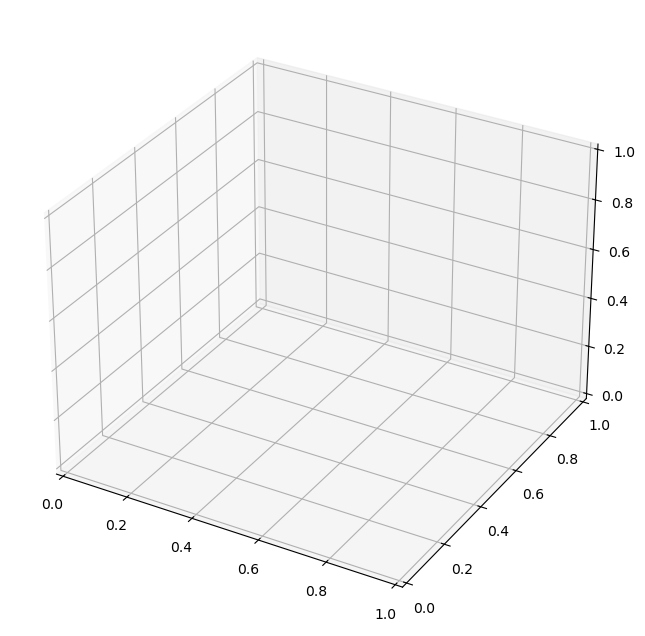

In [5]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
idx = ['log_L_lab', 'dominance', 'log_a_lab'];
#idx = ['val2_sin_hue', 'val2_cos_hue', 'saturation'];
#idx = ['ratio_rg', 'ratio_gb', 'ratio_br'];
#idx = ['L_lab', 'a_lab', 'b_lab']
colors = {'ripe': 'red', 'unripe': 'yellow'}
for label in colors:
    subset = colors_df[colors_df['label'] == label]
    ax.scatter(subset[idx[0]], subset[idx[1]], subset[idx[2]], c=colors[label], label=label,s=20)

ax.set_xlabel(idx[0])
ax.set_ylabel(idx[1])
ax.set_zlabel(idx[2])
ax.legend()
plt.show()


In [6]:
X = colors_df.drop(columns=['label'])
y = (colors_df['label'] == 'ripe').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
feature_list = X.columns.tolist()


false_negative_penalty = -15 # penalty - missed points
false_positive_penalty = -35 # - missed points

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    scale_pos_weight=(false_positive_penalty / false_negative_penalty),
    objective='binary:logistic',
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.7918367346938775
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       126
           1       0.77      0.82      0.79       119

    accuracy                           0.79       245
   macro avg       0.79      0.79      0.79       245
weighted avg       0.79      0.79      0.79       245



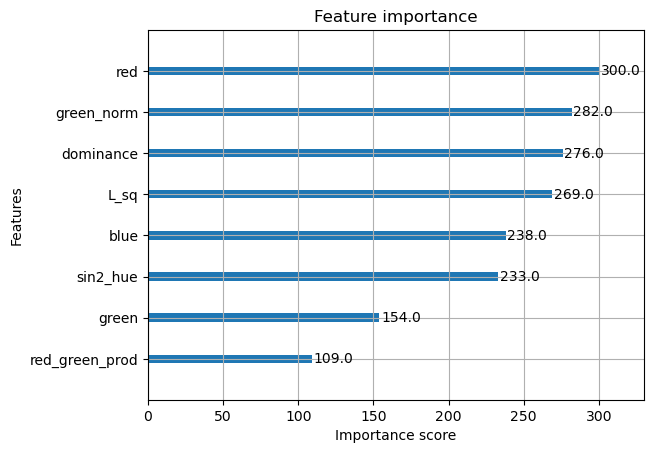

In [7]:
xgb.plot_importance(model, max_num_features=20)
plt.show()

single rule approximation, export tree as text

In [8]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, model.predict_proba(X_train)[:,1] > 0.5)

from sklearn.tree import export_text
print(export_text(dt, feature_names=list(X.columns)))
# 
# 
# pred = dt.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, pred))
# print(classification_report(y_test, pred))

|--- L_sq <= 1283.30
|   |--- dominance <= 0.00
|   |   |--- red <= 634.90
|   |   |   |--- class: False
|   |   |--- red >  634.90
|   |   |   |--- class: False
|   |--- dominance >  0.00
|   |   |--- red_green_prod <= 426842.97
|   |   |   |--- class: True
|   |   |--- red_green_prod >  426842.97
|   |   |   |--- class: False
|--- L_sq >  1283.30
|   |--- dominance <= 0.00
|   |   |--- L_sq <= 1299.03
|   |   |   |--- class: False
|   |   |--- L_sq >  1299.03
|   |   |   |--- class: False
|   |--- dominance >  0.00
|   |   |--- green_norm <= 0.32
|   |   |   |--- class: True
|   |   |--- green_norm >  0.32
|   |   |   |--- class: False



In [9]:
print(port(dt))


NameError: name 'port' is not defined